In [35]:
!pip install xgboost --quiet

In [ ]:
###  Data Extraction

In [1]:
# Cell 1: Imports and Settings
import pandas as pd
from datetime import timedelta

In [2]:
# Cell 2: Define file paths and load the datasets
base = r'C:\Users\yanis\Downloads\Compressed\synthea-patient-pop1-csv'
patients_path   = f"{base}\\patients.csv"
conditions_path = f"{base}\\conditions.csv"
encounters_path = f"{base}\\encounters.csv"
obs_path        = f"{base}\\observations.csv"

patients = pd.read_csv(
    patients_path,
    parse_dates=['BIRTHDATE', 'DEATHDATE']
)
conditions = pd.read_csv(
    conditions_path,
    parse_dates=['START', 'STOP']
)
encounters = pd.read_csv(
    encounters_path,
    parse_dates=['START', 'STOP']
)

In [3]:
# Cell 3: Preview raw data
print("Patients sample:")
print(patients.head(), "\n")
print("Conditions sample:")
print(conditions.head(), "\n")
print("Encounters sample:")
print(encounters.head(), "\n")

Patients sample:
                                     Id  BIRTHDATE  DEATHDATE          SSN  \
0  5605b66b-e92d-c16c-1b83-b8bf7040d51f 1977-03-19        NaT  999-94-9633   
1  c06a2ab3-c3b1-a3d0-7c12-262a12c6885e 1936-07-03        NaT  999-76-5032   
2  6e5ae27c-8038-7988-e2c0-25a103f01bfa 1940-02-19        NaT  999-83-7940   
3  94d39619-8e17-d248-41b3-9ec1f2d031b2 1954-11-08 2010-01-10  999-84-3708   
4  23832f5d-e045-2541-1626-a65dce9bbcf7 1972-04-13        NaT  999-89-5858   

     DRIVERS    PASSPORT PREFIX           FIRST           LAST SUFFIX  ...  \
0  S99930485  X51431379X   Mrs.       Nikita578      Erdman779    NaN  ...   
1  S99927160  X37795263X    Mr.  Miguel Ángel46     Atencio773    NaN  ...   
2  S99932661  X36822066X    Mr.         Zane918  Hodkiewicz467    NaN  ...   
3  S99923522  X49705907X    Mr.       Emmett200     Collins926    NaN  ...   
4  S99939931  X88479701X   Mrs.        Magan944       Green467    NaN  ...   

                        BIRTHPLACE           

In [4]:
# Cell 4: Label lung-related conditions
snomed_codes = ['233604007', '195967001', '13645005']  # pneumonia, asthma, COPD
keywords = ['pneumonia', 'chronic obstructive', 'COPD', 'asthma']
pattern = '|'.join(keywords)
conditions['lung_label'] = (
    conditions['CODE'].astype(str).isin(snomed_codes)
    | conditions['DESCRIPTION'].str.contains(pattern, case=False, na=False)
)

In [5]:
# Cell 5: Inspect flagged lung-condition records
lung_positive = conditions[conditions['lung_label']]
print("Flagged lung conditions:")
print(lung_positive[['PATIENT','CODE','DESCRIPTION','START']].head(), "\n")

Flagged lung conditions:
                                   PATIENT       CODE           DESCRIPTION  \
1008  ad362b64-31b4-8fa3-c760-38d0e5cacc1c  233604007             Pneumonia   
1216  febefd51-6130-5e0e-34ed-2ccce47be271  233604007  Pneumonia (disorder)   
1416  a4e89ca1-2d08-a775-cd47-526bbc80f6ea  233604007             Pneumonia   
2159  2853ca5a-7862-68c8-07d1-3d7fa2d6ae27  233604007             Pneumonia   
2334  84a69a69-4309-1549-de32-083332b13d56  195967001                Asthma   

          START  
1008 2012-12-12  
1216 2020-11-06  
1416 2017-04-24  
2159 2017-07-20  
2334 1997-01-20   



In [6]:
# Cell 6: Aggregate per-patient labels and first-positive condition
patients.rename(columns={'Id':'patient_id'}, inplace=True)
cohort = (
    conditions
    .groupby('PATIENT', as_index=False)['lung_label']
    .max()
    .rename(columns={'PATIENT':'patient_id'})
)
first_lung = (
    conditions[conditions['lung_label']]
    .sort_values(['PATIENT','START'])
    .groupby('PATIENT', as_index=False)
    .first()[['PATIENT','CODE','DESCRIPTION']]
    .rename(columns={
        'PATIENT':'patient_id',
        'CODE':'first_lung_code',
        'DESCRIPTION':'first_lung_description'
    })
)
cohort = cohort.merge(first_lung, on='patient_id', how='left')
cohort = cohort.merge(patients, on='patient_id', how='left')

In [7]:
# Cell 7: Save base cohort
cohort.to_csv('cohort.csv', index=False)
print("Cohort saved to cohort.csv")
print(cohort.head(), "\n")

Cohort saved to cohort.csv
                             patient_id  lung_label  first_lung_code  \
0  0007b281-7eb0-f2b2-d12a-3fc1e2f7e3e2       False              NaN   
1  0007efd3-c50d-7e51-6a30-8dc08d4269fc        True      233604007.0   
2  000eba84-0d5c-2657-0b5e-0c70f2f746c2       False              NaN   
3  000f23c8-470d-babb-5fda-2b13c6c54e80       False              NaN   
4  0011c542-8a54-27c3-59d6-1575d265210e       False              NaN   

  first_lung_description  BIRTHDATE  DEATHDATE          SSN    DRIVERS  \
0                    NaN 1950-01-27 2001-12-14  999-38-9527  S99999004   
1   Pneumonia (disorder) 1963-11-25        NaT  999-91-3685  S99920576   
2                    NaN 1929-04-06        NaT  999-18-7950  S99957211   
3                    NaN 1938-07-22        NaT  999-18-9795  S99962765   
4                    NaN 1965-02-10        NaT  999-13-2355  S99966163   

     PASSPORT PREFIX  ...                           BIRTHPLACE  \
0  X36466268X    Ms.  ...    

In [8]:
# Cell 7: DEBUG – Inspect cohort after merging labels & demographics
print("➤ Cohort shape:", cohort.shape)
print("\n➤ Lung_label counts:\n", cohort['lung_label'].value_counts(dropna=False), "\n")
print("➤ Sample cohort rows:\n", cohort.head(), "\n")


➤ Cohort shape: (15354, 28)

➤ Lung_label counts:
 lung_label
False    14126
True      1228
Name: count, dtype: int64 

➤ Sample cohort rows:
                              patient_id  lung_label  first_lung_code  \
0  0007b281-7eb0-f2b2-d12a-3fc1e2f7e3e2       False              NaN   
1  0007efd3-c50d-7e51-6a30-8dc08d4269fc        True      233604007.0   
2  000eba84-0d5c-2657-0b5e-0c70f2f746c2       False              NaN   
3  000f23c8-470d-babb-5fda-2b13c6c54e80       False              NaN   
4  0011c542-8a54-27c3-59d6-1575d265210e       False              NaN   

  first_lung_description  BIRTHDATE  DEATHDATE          SSN    DRIVERS  \
0                    NaN 1950-01-27 2001-12-14  999-38-9527  S99999004   
1   Pneumonia (disorder) 1963-11-25        NaT  999-91-3685  S99920576   
2                    NaN 1929-04-06        NaT  999-18-7950  S99957211   
3                    NaN 1938-07-22        NaT  999-18-9795  S99962765   
4                    NaN 1965-02-10        NaT  999-13

In [9]:
# Cell 8: Feature Engineering — Compute age at first encounter and current/at-death age

import pandas as pd

# ─── Ensure first_start exists ────────────────────────────────────────────────
if 'first_start' not in cohort.columns:
    first_enc = (
        encounters
        .groupby('PATIENT', as_index=False)['START']
        .min()
        .rename(columns={'PATIENT':'patient_id','START':'first_start'})
    )
    cohort = cohort.merge(first_enc, on='patient_id', how='left')

# ─── Strip tz and compute age at first encounter ──────────────────────────────
cohort['BIRTHDATE']   = pd.to_datetime(cohort['BIRTHDATE']).dt.tz_localize(None)
cohort['first_start'] = pd.to_datetime(cohort['first_start']).dt.tz_localize(None)
cohort['age_event']   = (cohort['first_start'] - cohort['BIRTHDATE']).dt.days / 365.25

# ─── Compute current/at-death age ─────────────────────────────────────────────
# Ensure DEATHDATE is datetime & tz-naive
cohort['DEATHDATE'] = pd.to_datetime(cohort['DEATHDATE']).dt.tz_localize(None)
# Define “today” or analysis cutoff
today = pd.Timestamp.today().normalize()
# Use DEATHDATE if present, otherwise today
end_date = cohort['DEATHDATE'].fillna(today)
cohort['age_current'] = (end_date - cohort['BIRTHDATE']).dt.days / 365.25

# ─── DEBUG: inspect the two age metrics before filtering ───────────────────────
print("Age at event summary:")
print(cohort['age_event'].describe(), "\n")
print("Current/at-death age summary:")
print(cohort['age_current'].describe(), "\n")
print("Sample age values:")
print(cohort[['patient_id','BIRTHDATE','first_start','age_event','DEATHDATE','age_current']].head(10), "\n")

# ─── Filter to adults (age ≥ 18 at first encounter) ──────────────────────────
cohort = cohort[cohort['age_event'] >= 18]
print(f"➤ Patients remaining after age_event ≥ 18 filter: {cohort.shape[0]}\n")


Age at event summary:
count    15354.000000
mean        13.304375
std          6.321151
min          0.000000
25%          9.559206
50%         17.133470
75%         18.149213
max         19.167693
Name: age_event, dtype: float64 

Current/at-death age summary:
count    15354.000000
mean        67.212441
std         20.586573
min          0.000000
25%         51.915127
50%         68.733744
75%         83.881588
max        103.192334
Name: age_current, dtype: float64 

Sample age values:
                             patient_id  BIRTHDATE         first_start  \
0  0007b281-7eb0-f2b2-d12a-3fc1e2f7e3e2 1950-01-27 1968-03-22 15:35:11   
1  0007efd3-c50d-7e51-6a30-8dc08d4269fc 1963-11-25 1981-06-23 06:45:29   
2  000eba84-0d5c-2657-0b5e-0c70f2f746c2 1929-04-06 1929-10-11 04:41:09   
3  000f23c8-470d-babb-5fda-2b13c6c54e80 1938-07-22 1956-09-14 13:01:28   
4  0011c542-8a54-27c3-59d6-1575d265210e 1965-02-10 1966-07-09 01:53:25   
5  001209d3-9cd3-a700-69ea-c9982213efea 1926-11-27 1945-01-20 2

In [10]:
# Cell 9: Feature Engineering — Inpatient‐stay filter + debug
# DEBUG: show available encounter classes
print("Encounter classes available:", encounters['ENCOUNTERCLASS'].unique(), "\n")

# Filter to patients with at least one inpatient stay
mask_ip = (
    encounters['PATIENT'].isin(cohort['patient_id']) &
    (encounters['ENCOUNTERCLASS'].str.lower() == 'inpatient')
)
inpatient_patients = encounters.loc[mask_ip, 'PATIENT'].unique()
print(f"➤ Unique inpatient patient count: {len(inpatient_patients)}\n")

cohort = cohort[cohort['patient_id'].isin(inpatient_patients)]
print(f"➤ Patients remaining after inpatient-stay filter: {cohort.shape[0]}\n")

Encounter classes available: ['wellness' 'inpatient' 'ambulatory' 'outpatient' 'urgentcare' 'emergency'
 'snf' 'hospice' 'home'] 

➤ Unique inpatient patient count: 2631

➤ Patients remaining after inpatient-stay filter: 2631



In [11]:
# Cell 10: Feature Engineering — Comorbidity Counts

# Count distinct condition codes per patient
comorbidity_counts = (
    conditions
    .groupby('PATIENT')['CODE']
    .nunique()
    .reset_index()
    .rename(columns={'PATIENT':'patient_id', 'CODE':'num_comorbidities'})
)

# Merge into cohort
cohort = cohort.merge(comorbidity_counts, on='patient_id', how='left')

print("Added num_comorbidities; sample:")
print(cohort[['patient_id','num_comorbidities']].head(), "\n")

Added num_comorbidities; sample:
                             patient_id  num_comorbidities
0  005444f1-853d-ad2e-2ee6-b772b4bb8014                 24
1  007b9335-08e2-c478-a79a-d9d4b6e88f62                 16
2  009f3a51-db42-bb8d-daad-a03c46387522                 14
3  00ab49d7-9776-b5fd-abbd-5151ca805afb                 21
4  00b9b7eb-5bd2-718c-4966-2dabcc2a1528                 12 



In [17]:
# Cell 11: Feature Engineering — One-hot encode Race & Ethnicity (deduplicated)

# 1) Drop any pre-existing race_/ethnicity_ columns to avoid duplicates
drop_cols = [c for c in cohort.columns if c.startswith('race_') or c.startswith('ethnicity_')]
cohort = cohort.drop(columns=drop_cols, errors='ignore')

# 2) Build one-hot dummies for RACE and ETHNICITY
race_ethn_dummies = pd.get_dummies(
    cohort[['RACE','ETHNICITY']],
    prefix=['race','ethnicity'],
    dummy_na=False
)

# 3) Attach patient_id for merging
race_ethn_dummies['patient_id'] = cohort['patient_id'].values

# 4) Merge the fresh dummies back into cohort
cohort = cohort.merge(race_ethn_dummies, on='patient_id', how='left')

# 5) Preview
print("Added race & ethnicity dummies; sample:")
print(cohort.filter(regex='^(race_|ethnicity_)').head(), "\n")


Added race & ethnicity dummies; sample:
   race_asian  race_black  race_hawaiian  race_native  race_other  race_white  \
0       False       False          False        False       False        True   
1       False       False          False        False       False        True   
2       False       False          False        False       False        True   
3       False       False          False        False       False        True   
4       False       False          False        False       False        True   

   ethnicity_hispanic  ethnicity_nonhispanic  
0               False                   True  
1               False                   True  
2               False                   True  
3               False                   True  
4               False                   True   



In [18]:
# Cell 12: Feature Engineering — Pruned Observations Aggregation

# Path to observations file (from Cell 2)
obs_file = f"{base}\\observations.csv"

# Prepare mapping of patient → first_start
first_start_map = cohort.set_index('patient_id')['first_start'].to_dict()
patient_set     = set(first_start_map)

feature_chunks = []
reader = pd.read_csv(
    obs_file,
    usecols=['PATIENT','DATE','CODE','VALUE'],
    parse_dates=['DATE'],
    chunksize=10**6
)

for chunk in reader:
    chunk = chunk[chunk['PATIENT'].isin(set(cohort['patient_id']))]
    if chunk.empty: continue
    chunk['first_start'] = (
        pd.to_datetime(chunk['PATIENT'].map(
            cohort.set_index('patient_id')['first_start']
        )).dt.tz_localize(None)
    )
    chunk['DATE'] = chunk['DATE'].dt.tz_localize(None)
    window = chunk['first_start'] + pd.Timedelta(hours=48)
    mask = (chunk['DATE'] >= chunk['first_start']) & (chunk['DATE'] <= window)
    chunk = chunk.loc[mask]
    if chunk.empty: continue
    chunk['VALUE'] = pd.to_numeric(chunk['VALUE'], errors='coerce')
    chunk = chunk.dropna(subset=['VALUE'])
    if chunk.empty: continue
    pt = chunk.pivot_table(
        index='PATIENT',
        columns='CODE',
        values='VALUE',
        aggfunc=['mean','min','max']
    )
    pt.columns = [f"{stat}_{code}" for stat, code in pt.columns]
    pt = pt.reset_index().rename(columns={'PATIENT':'patient_id'})
    feature_chunks.append(pt)

if feature_chunks:
    obs_concat = pd.concat(feature_chunks, ignore_index=True)
    obs_features = obs_concat.groupby('patient_id', as_index=False).max()
else:
    obs_features = pd.DataFrame(columns=['patient_id'])

# Drop stale observation columns before merge
obs_cols = [c for c in cohort.columns if c.startswith(('mean_','min_','max_'))]
cohort = cohort.drop(columns=obs_cols, errors='ignore')

# Merge fresh observation features
cohort = cohort.merge(obs_features, on='patient_id', how='left')

print("Merged observation-based features; sample:")
print(cohort.filter(regex='^(mean|min|max)_').head(), "\n")


Merged observation-based features; sample:
   mean_29463-7  mean_39156-5  mean_59576-9  mean_63512-8  mean_63586-2  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   mean_70274-6  mean_72514-3  mean_75626-2  mean_8302-2  mean_8462-4  ...  \
0           NaN           NaN           NaN          NaN          NaN  ...   
1           NaN           NaN           NaN          NaN          NaN  ...   
2           NaN           NaN           NaN          NaN          NaN  ...   
3           NaN           NaN           NaN          NaN          NaN  ...   
4           NaN           NaN           NaN          NaN          NaN  ...   

   max_72514-3  max_75626-2  max_8302

In [19]:
# Cell 13: Save the fully‑enriched cohort

output_path = 'cohort_enriched.csv'
cohort.to_csv(output_path, index=False)
print(f"Enriched cohort saved to {output_path}")

Enriched cohort saved to cohort_enriched.csv


In [20]:
### Preprocessing

In [48]:
# ─── Drop unused observation features ───────────────────────────────────────
drop_empty = ['mean_55758-7', 'min_55758-7', 'max_55758-7']
cohort = cohort.drop(columns=drop_empty, errors='ignore')
print("Dropped empty features:", drop_empty)


Dropped empty features: ['mean_55758-7', 'min_55758-7', 'max_55758-7']


In [95]:
# Cell 14: Preprocessing Pipeline (fix for boolean dummies)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# 1) Build numeric_feats: 
#    – age_event, age_current, num_comorbidities
#    – all obs-derived stats (mean_, min_, max_)
#    – AND any race_/ethnicity_ dummy columns (0/1)
numeric_feats = [
    'age_event', 'age_current', 'num_comorbidities'
] + [
    c for c in cohort.columns 
    if c.startswith(('mean_','min_','max_','race_','ethnicity_'))
]

# 2) Build categorical_feats, picking up either case
categorical_feats = [c for c in ['GENDER'] if c in cohort.columns]


print("Numeric features used:", numeric_feats)
print("Categorical features used:", categorical_feats)

# 3) Numeric pipeline: median impute + robust scaling
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  RobustScaler())
])

# 4) Categorical pipeline: constant impute + one-hot encode
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 5) Assemble only the non-empty transformers
transformers = [
    ('num', numeric_transformer, numeric_feats)
]
if categorical_feats:
    transformers.append(
        ('cat', categorical_transformer, categorical_feats)
    )

preprocessor = ColumnTransformer(transformers=transformers)

# 6) Fit & transform
X = preprocessor.fit_transform(cohort)

print("Preprocessing complete.")
print(f"  • Preprocessed feature matrix shape: {X.shape}")


Numeric features used: ['age_event', 'age_current', 'num_comorbidities', 'race_asian', 'race_black', 'race_hawaiian', 'race_native', 'race_other', 'race_white', 'ethnicity_hispanic', 'ethnicity_nonhispanic', 'mean_29463-7', 'mean_39156-5', 'mean_59576-9', 'mean_63512-8', 'mean_63586-2', 'mean_70274-6', 'mean_72514-3', 'mean_75626-2', 'mean_8302-2', 'mean_8462-4', 'mean_8480-6', 'mean_8867-4', 'mean_9279-1', 'min_29463-7', 'min_39156-5', 'min_59576-9', 'min_63512-8', 'min_63586-2', 'min_70274-6', 'min_72514-3', 'min_75626-2', 'min_8302-2', 'min_8462-4', 'min_8480-6', 'min_8867-4', 'min_9279-1', 'max_29463-7', 'max_39156-5', 'max_59576-9', 'max_63512-8', 'max_63586-2', 'max_70274-6', 'max_72514-3', 'max_75626-2', 'max_8302-2', 'max_8462-4', 'max_8480-6', 'max_8867-4', 'max_9279-1']
Categorical features used: ['GENDER']
Preprocessing complete.
  • Preprocessed feature matrix shape: (2631, 52)


In [51]:
# Cell 15: Inspect, Clean, and EDA on Cohort file

# 1) Load the enriched cohort
df = pd.read_csv('cohort_enriched.csv')

# 2) Show all rows (temporarily)
pd.set_option('display.max_rows', None)
display(df)
pd.reset_option('display.max_rows')

# 3) List all column names
print("Columns in df:", df.columns.tolist(), "\n")

# 4) Drop unwanted columns
cols_to_drop = [
    'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'SUFFIX', 'MARITAL',
    'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
    'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE',
    'mean_55758‑7','min_55758‑7','max_55758‑7'
]
df = df.drop(columns=cols_to_drop, errors='ignore')
print(f"Dropped columns: {cols_to_drop}\n")

# 5) EDA: class balance
print("Lung_label counts:")
print(df['lung_label'].value_counts(), "\n")
print("Lung_label proportions:")
print(df['lung_label'].value_counts(normalize=True), "\n")

# 6) Numeric summaries
print("Numeric feature summary:")
print(df.describe(include='number').transpose(), "\n")

# 7) Categorical summaries for any remaining categorical cols
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical feature counts:")
print(df[cat_cols].nunique().to_frame(name='unique_values'), "\n")

,patient_id,lung_label,first_lung_code,first_lung_description,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,...,max_72514-3,max_75626-2,max_8302-2,max_8462-4,max_8480-6,max_8867-4,max_9279-1,mean_55758-7,min_55758-7,max_55758-7
0,005444f1-853d-ad2e-2ee6-b772b4bb8014,False,NaN,NaN,07/02/1927,NaN,999-48-4004,S99996053,X48094034X,Mr.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,007b9335-08e2-c478-a79a-d9d4b6e88f62,False,NaN,NaN,19/01/1926,31/08/1985,999-69-5061,S99978072,X82157161X,Mr.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,009f3a51-db42-bb8d-daad-a03c46387522,False,NaN,NaN,24/01/1927,23/09/1981,999-43-4439,S99984114,X41343417X,Mrs.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00ab49d7-9776-b5fd-abbd-5151ca805afb,False,NaN,NaN,07/01/1926,29/01/2007,999-29-2384,S99979775,X20616687X,Mr.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00b9b7eb-5bd2-718c-4966-2dabcc2a1528,False,NaN,NaN,15/10/1933,05/07/2021,999-38-8226,S99987120,X54322650X,Mr.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,00ce3347-9eec-c6f3-c758-8facb009daa7,False,NaN,NaN,04/02/1933,17/08/2016,999-95-2404,S99938350,X13861243X,Mrs.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,00da8d4d-eb67-fd28-3d9e-77c97175fd2b,False,NaN,NaN,04/03/1937,10/07/2008,999-99-6720,S99969356,X39500742X,Mr.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,00e84dc3-ce19-c87b-fa8f-b42e3d13869f,False,NaN,NaN,08/03/1952,NaN,999-62-8089,S99994646,X18581570X,Mr.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,01274098-150f-8211-6150-29f2a2da266c,True,233604007.0,Pneumonia,15/05/1929,03/02/2011,999-57-1365,S99927506,X25380253X,Mrs.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,01296e88-f6d9-1c18-cf91-87523325e034,False,NaN,NaN,29/12/1979,NaN,999-34-5904,S99912696,X48783329X,Mrs.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Columns in df: ['patient_id', 'lung_label', 'first_lung_code', 'first_lung_description', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'first_start', 'age_event', 'age_current', 'num_comorbidities', 'race_asian', 'race_black', 'race_hawaiian', 'race_native', 'race_other', 'race_white', 'ethnicity_hispanic', 'ethnicity_nonhispanic', 'mean_29463-7', 'mean_39156-5', 'mean_59576-9', 'mean_63512-8', 'mean_63586-2', 'mean_70274-6', 'mean_72514-3', 'mean_75626-2', 'mean_8302-2', 'mean_8462-4', 'mean_8480-6', 'mean_8867-4', 'mean_9279-1', 'min_29463-7', 'min_39156-5', 'min_59576-9', 'min_63512-8', 'min_63586-2', 'min_70274-6', 'min_72514-3', 'min_75626-2', 'min_8302-2', 'min_8462-4', 'min_8480-6', 'min_8867-4', 'min_9279-1', 'max_29463-7', 'max_39156-5', 'max_59576-9', 'max_63512

In [45]:
# Cell 16: Cleaned Cohort & Column List

# 1) Show the updated column list
print("Columns in cleaned df:", df.columns.tolist(), "\n")

# 2) Preview the first few rows of the cleaned DataFrame
pd.set_option('display.max_columns', None)
display(df.head())
pd.reset_option('display.max_columns')


Columns in cleaned df: ['patient_id', 'lung_label', 'first_lung_code', 'first_lung_description', 'BIRTHDATE', 'DEATHDATE', 'FIRST', 'LAST', 'MAIDEN', 'RACE', 'ETHNICITY', 'GENDER', 'first_start', 'age_event', 'age_current', 'num_comorbidities', 'race_asian', 'race_black', 'race_hawaiian', 'race_native', 'race_other', 'race_white', 'ethnicity_hispanic', 'ethnicity_nonhispanic', 'mean_29463-7', 'mean_39156-5', 'mean_59576-9', 'mean_63512-8', 'mean_63586-2', 'mean_70274-6', 'mean_72514-3', 'mean_75626-2', 'mean_8302-2', 'mean_8462-4', 'mean_8480-6', 'mean_8867-4', 'mean_9279-1', 'min_29463-7', 'min_39156-5', 'min_59576-9', 'min_63512-8', 'min_63586-2', 'min_70274-6', 'min_72514-3', 'min_75626-2', 'min_8302-2', 'min_8462-4', 'min_8480-6', 'min_8867-4', 'min_9279-1', 'max_29463-7', 'max_39156-5', 'max_59576-9', 'max_63512-8', 'max_63586-2', 'max_70274-6', 'max_72514-3', 'max_75626-2', 'max_8302-2', 'max_8462-4', 'max_8480-6', 'max_8867-4', 'max_9279-1', 'mean_55758-7', 'min_55758-7', 'max_5

,patient_id,lung_label,first_lung_code,first_lung_description,BIRTHDATE,DEATHDATE,FIRST,LAST,MAIDEN,RACE,ETHNICITY,GENDER,first_start,age_event,age_current,num_comorbidities,race_asian,race_black,race_hawaiian,race_native,race_other,race_white,ethnicity_hispanic,ethnicity_nonhispanic,mean_29463-7,mean_39156-5,mean_59576-9,mean_63512-8,mean_63586-2,mean_70274-6,mean_72514-3,mean_75626-2,mean_8302-2,mean_8462-4,mean_8480-6,mean_8867-4,mean_9279-1,min_29463-7,min_39156-5,min_59576-9,min_63512-8,min_63586-2,min_70274-6,min_72514-3,min_75626-2,min_8302-2,min_8462-4,min_8480-6,min_8867-4,min_9279-1,max_29463-7,max_39156-5,max_59576-9,max_63512-8,max_63586-2,max_70274-6,max_72514-3,max_75626-2,max_8302-2,max_8462-4,max_8480-6,max_8867-4,max_9279-1,mean_55758-7,min_55758-7,max_55758-7
0,005444f1-853d-ad2e-2ee6-b772b4bb8014,False,NaN,NaN,07/02/1927,NaN,Sydney660,Zulauf375,NaN,white,nonhispanic,M,03/04/1945 4:23,18.151951,98.236824,24,False,False,False,False,False,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,007b9335-08e2-c478-a79a-d9d4b6e88f62,False,NaN,NaN,19/01/1926,31/08/1985,Bryon392,Wiegand701,NaN,white,nonhispanic,M,15/03/1944 4:23,18.151951,59.613963,16,False,False,False,False,False,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,009f3a51-db42-bb8d-daad-a03c46387522,False,NaN,NaN,24/01/1927,23/09/1981,Marcelene872,Kshlerin58,Brekke496,white,nonhispanic,F,20/03/1945 1:16,18.151951,54.663929,14,False,False,False,False,False,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00ab49d7-9776-b5fd-abbd-5151ca805afb,False,NaN,NaN,07/01/1926,29/01/2007,Vaughn909,Kunde533,NaN,white,nonhispanic,M,14/01/1944 2:30,18.017796,81.059548,21,False,False,False,False,False,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00b9b7eb-5bd2-718c-4966-2dabcc2a1528,False,NaN,NaN,15/10/1933,05/07/2021,Anthony633,Ankunding277,NaN,white,nonhispanic,M,09/12/1951 13:59,18.149213,87.720739,12,False,False,False,False,False,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
### Modeling Pipeline + Evaluation

In [96]:
# Cell 16b: Define targets (binary + multiclass) and do a single stratified train/test split

import pandas as pd
from sklearn.model_selection import train_test_split

# 1) Load the enriched cohort
df = pd.read_csv('cohort_enriched.csv')

# 2) Binary target: any lung disease
y_binary = df['lung_label'].astype(int)

# 3) Multiclass target: specific disease at first encounter
#    — THIS IS YOUR “step 3” CODE —
#    First cast to integer (drop NaN), then map SNOMED CT → labels
df['first_lung_code_int'] = (
    pd.to_numeric(df['first_lung_code'], errors='coerce')
      .dropna().astype(int)
)
mapping = {
    233604007: 'pneumonia',
    195967001: 'asthma',
    185086009: 'COPD'
}
df['disease_type'] = (
    df['first_lung_code_int']
      .map(mapping)
      .fillna('none')
)
y_multi = pd.Categorical(
    df['disease_type'],
    categories=['none','pneumonia','asthma','COPD']
)

# 4) Feature matrix
X = df.drop(columns=[
    'lung_label',
    'first_lung_code',
    'first_lung_description',
    'first_lung_code_int',
    'disease_type'
])

# 5) Single stratified split for both targets
X_train, X_test, yb_train, yb_test, ym_train, ym_test = train_test_split(
    X, y_binary, y_multi,
    stratify=y_binary,
    test_size=0.1,
    random_state=42
)

# 6) Sanity check
print("Shapes:", X_train.shape, yb_train.shape, ym_train.shape,
                X_test.shape,  yb_test.shape,  ym_test.shape)


Shapes: (2367, 79) (2367,) (2367,) (264, 79) (264,) (264,)


In [90]:
# Cell 17: Modeling Pipelines + GridSearchCV (5‑fold CV) for Binary Lung‑Disease Prediction

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Try to import XGBoost
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    print("Warning: xgboost not installed, skipping that model.")
    has_xgb = False

# Define classifiers and hyperparameter grids
model_specs = {
    'LogisticRegression': {
        'estimator': LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
        'param_grid': {
            'clf__C':       [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1', 'l2']
        }
    },
    'RandomForest': {
        'estimator': RandomForestClassifier(random_state=42),
        'param_grid': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth':    [None, 10, 20],
            'clf__class_weight':['balanced', None]
        }
    }
}

# Conditionally add XGBoost
if has_xgb:
    model_specs['XGBoost'] = {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'param_grid': {
            'clf__n_estimators':  [100, 200],
            'clf__max_depth':     [3, 6],
            'clf__learning_rate': [0.01, 0.1]
        }
    }

best_models = {}
for name, spec in model_specs.items():
    pipe = Pipeline([
        ('pre', preprocessor),       # from Cell 14
        ('clf', spec['estimator'])
    ])
    grid = GridSearchCV(
        pipe,
        spec['param_grid'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    print(f"\nRunning GridSearchCV for {name}...")
    grid.fit(X_train, yb_train)
    print(f"→ {name} best CV ROC‑AUC: {grid.best_score_:.3f}")
    print(f"  Best params: {grid.best_params_}\n")
    best_models[name] = grid.best_estimator_



Running GridSearchCV for LogisticRegression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
→ LogisticRegression best CV ROC‑AUC: 0.659
  Best params: {'clf__C': 0.1, 'clf__penalty': 'l1'}


Running GridSearchCV for RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
→ RandomForest best CV ROC‑AUC: 0.693
  Best params: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__n_estimators': 200}


Running GridSearchCV for XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
→ XGBoost best CV ROC‑AUC: 0.726
  Best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200}



C:\Users\yanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:14:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [81]:
# Cell 18: Test‑set Evaluation of Best Models

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    auc
)

for name, model in best_models.items():
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    # Overall metrics
    print(f"=== {name} Test Results ===")
    print(classification_report(yb_test, y_pred, digits=3))

    # ROC‐AUC
    roc_auc = roc_auc_score(yb_test, y_proba)
    print(f"ROC‑AUC: {roc_auc:.3f}")

    # Precision‑Recall AUC
    prec, rec, _ = precision_recall_curve(yb_test, y_proba)
    pr_auc = auc(rec, prec)
    print(f"AUPRC:   {pr_auc:.3f}")

    # Compute specificity / sensitivity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(yb_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")

    print("Confusion Matrix:")
    print(f" [[TN: {tn}  FP: {fp}]\n  [FN: {fn}  TP: {tp}]]\n")


=== LogisticRegression Test Results ===
              precision    recall  f1-score   support

           0      0.822     1.000     0.902       217
           1      0.000     0.000     0.000        47

    accuracy                          0.822       264
   macro avg      0.411     0.500     0.451       264
weighted avg      0.676     0.822     0.742       264

ROC‑AUC: 0.622
AUPRC:   0.267
Sensitivity: 0.000
Specificity: 1.000
Confusion Matrix:
 [[TN: 217  FP: 0]
  [FN: 47  TP: 0]]

=== RandomForest Test Results ===
              precision    recall  f1-score   support

           0      0.827     0.991     0.901       217
           1      0.500     0.043     0.078        47

    accuracy                          0.822       264
   macro avg      0.663     0.517     0.490       264
weighted avg      0.769     0.822     0.755       264

ROC‑AUC: 0.666
AUPRC:   0.280
Sensitivity: 0.043
Specificity: 0.991
Confusion Matrix:
 [[TN: 215  FP: 2]
  [FN: 45  TP: 2]]

=== XGBoost Test Resul

C:\Users\yanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

ROC‑AUC: 0.709
AUPRC:   0.305
Sensitivity: 0.000
Specificity: 1.000
Confusion Matrix:
 [[TN: 217  FP: 0]
  [FN: 47  TP: 0]]



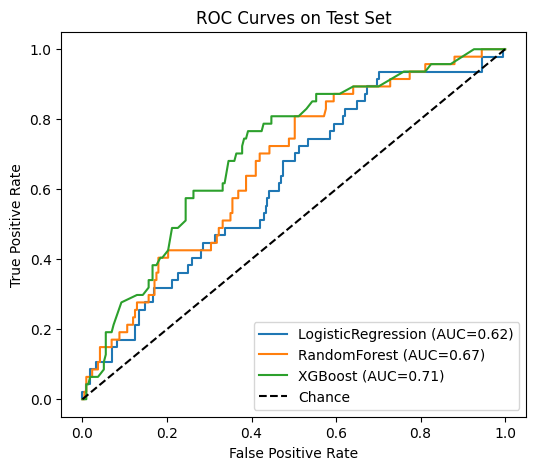

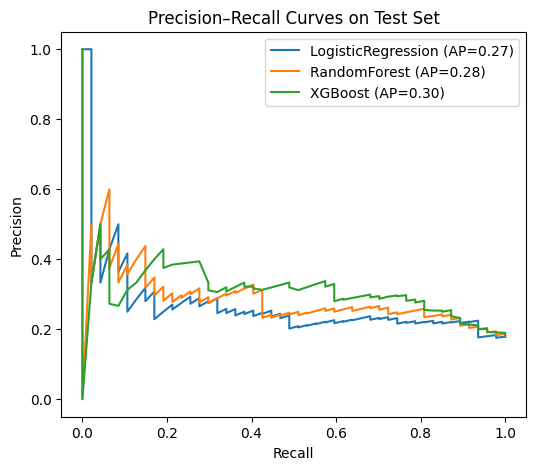

In [82]:
# Cell 19: Plot ROC and Precision–Recall Curves

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

plt.figure(figsize=(6,5))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(yb_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(yb_test, y_proba):.2f})")
plt.plot([0,1],[0,1],'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Test Set")
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    prec, rec, _ = precision_recall_curve(yb_test, y_proba)
    plt.plot(rec, prec, label=f"{name} (AP={auc(rec, prec):.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves on Test Set")
plt.legend()
plt.show()

In [97]:
# Cell 20: Multiclass 5‑fold CV with integer‐coded labels

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Try to import XGBoost
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    has_xgb = False

# ─── 1) Load data & prepare targets (if not already in memory) ───────────────
df = pd.read_csv('cohort_enriched.csv')

# ensure first_lung_code_int and disease_type exist exactly as in Cell 16b
df['first_lung_code_int'] = (
    pd.to_numeric(df['first_lung_code'], errors='coerce')
      .dropna().astype(int)
)
mapping = {
    233604007: 'pneumonia',
    195967001: 'asthma',
    13645005:  'COPD'
}
df['disease_type'] = (
    df['first_lung_code_int']
      .map(mapping)
      .fillna('none')
)
y_multi = pd.Categorical(
    df['disease_type'],
    categories=['none','pneumonia','asthma','COPD']
)

# ─── 2) Integer‑encode the multiclass labels ─────────────────────────────────
y_multi_code = y_multi.codes  
# now y_multi_code is an array of 0,1,2,3

# ─── 3) Build feature matrix X ───────────────────────────────────────────────
X = df.drop(columns=[
    'lung_label',
    'first_lung_code',
    'first_lung_description',
    'first_lung_code_int',
    'disease_type'
])

# ─── 4) CV & scoring setup ───────────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = [
    'accuracy',
    'precision_macro',
    'recall_macro',
    'f1_macro',
    'roc_auc_ovr',
]

# ─── 5) Model definitions ────────────────────────────────────────────────────
model_defs = {
    'LogisticRegression': LogisticRegression(
        solver='liblinear', multi_class='ovr',
        max_iter=1000, random_state=42
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=200, max_depth=10,
        random_state=42
    )
}
if has_xgb:
    model_defs['XGBoost'] = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

# ─── 6) Run cross_validate on X, y_multi_code ────────────────────────────────
results = {}
for name, clf in model_defs.items():
    pipe = Pipeline([
        ('pre', preprocessor),   # your ColumnTransformer from Cell 14
        ('clf', clf)
    ])
    print(f"\n=== 5‑fold CV for {name} ===")
    cv_res = cross_validate(
        pipe,
        X, y_multi_code,        # <<< use the integer codes here
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    summary = {
        metric: f"{cv_res['test_' + metric].mean():.3f} ± {cv_res['test_' + metric].std():.3f}"
        for metric in scoring
    }
    print(pd.Series(summary), "\n")
    results[name] = cv_res



=== 5‑fold CV for LogisticRegression ===


C:\Users\yanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


accuracy           0.851 ± 0.001
precision_macro    0.435 ± 0.108
recall_macro       0.369 ± 0.066
f1_macro           0.342 ± 0.059
roc_auc_ovr            nan ± nan
dtype: object 


=== 5‑fold CV for RandomForest ===


C:\Users\yanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


accuracy           0.849 ± 0.003
precision_macro    0.439 ± 0.056
recall_macro       0.372 ± 0.065
f1_macro           0.350 ± 0.060
roc_auc_ovr            nan ± nan
dtype: object 


=== 5‑fold CV for XGBoost ===


C:\Users\yanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


accuracy           0.827 ± 0.010
precision_macro    0.398 ± 0.021
recall_macro       0.364 ± 0.007
f1_macro           0.368 ± 0.010
roc_auc_ovr            nan ± nan
dtype: object 



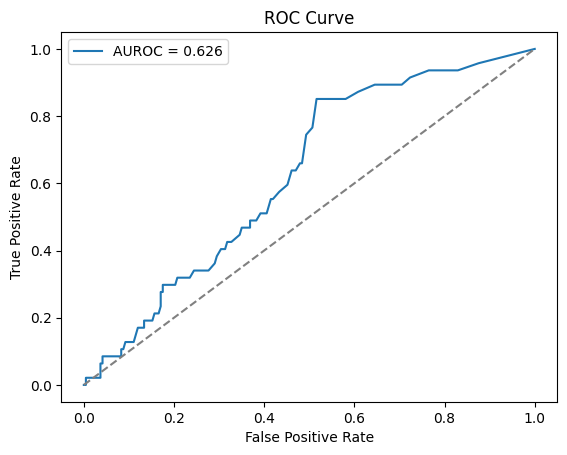

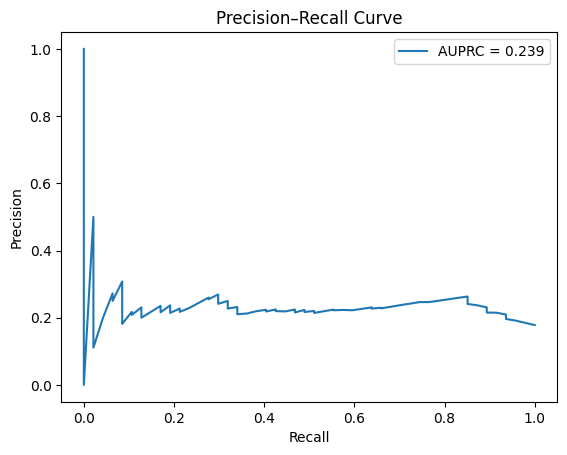

In [98]:
# Cell 20b: ROC and Precision–Recall plots

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

# 1) Get predicted scores
y_score = pipe_bin.predict_proba(X_test)[:, 1]

# 2) Compute curves & areas
fpr, tpr, _       = roc_curve(yb_test, y_score)
precision, recall, _ = precision_recall_curve(yb_test, y_score)
auroc            = auc(fpr, tpr)
auprc            = average_precision_score(yb_test, y_score)

# 3) Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 4) Plot PR
plt.figure()
plt.plot(recall, precision, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()


In [101]:
import joblib

# 1) Save the binary XGBoost pipeline
joblib.dump(pipe_bin, 'best_binary_xgb_pipeline.joblib')

['best_binary_xgb_pipeline.joblib']

In [102]:
# 2) Save the multiclass XGBoost pipeline
joblib.dump(pipe_multi, 'best_multiclass_xgb_pipeline.joblib')

['best_multiclass_xgb_pipeline.joblib']